# 代码实现

由于Faster R-CNN代码架构过于庞大，我们将直接调用相关接口进行效果展示。先导入必要的包，并使用在MS COCO数据集上预训练的ResNet50作为主干网络。

In [ ]:
import os
import numpy as np
import functools
import matplotlib.pyplot as plt
import cv2
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [ ]:
! pip install -U 'git+https://github.com/MS COCOdataset/MS COCOapi.git#subdirectory=PythonAPI'
! git clone https://github.com/pytorch/vision.git
! cd vision;cp references/detection/utils.py ../
! cp references/detection/transforms.py ../
! cp references/detection/MS COCO_eval.py ../
! cp references/detection/engine.py ../
! cp references/detection/MS COCO_utils.py ../

In [ ]:
# 加载模型，使用MS COCO数据集预训练
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained='MS COCO')
num_classes = 21  
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# 初始化优化器与学习率
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [ ]:
WEIGHTS_FILE = "../input/fasterrcnn/faster_rcnn_state.pth"
model.load_state_dict(torch.load(WEIGHTS_FILE))

<All keys matched successfully>

接着，编写模型测试的代码。

In [ ]:
# 对模型进行测试
def obj_detector(img):
    img = cv2.imread(img, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)

    # 导入图像并对图像进行处理
    img /= 255.0
    img = torch.from_numpy(img)
    img = img.unsqueeze(0)
    img = img.permute(0,3,1,2)
    
    model.eval()
    
    # 设置阈值
    detection_threshold = 0.70
    
    img = list(im.to(device) for im in img)
    output = model(img)

    for i , im in enumerate(img):
        boxes = output[i]['boxes'].data.cpu().numpy()
        scores = output[i]['scores'].data.cpu().numpy()
        labels = output[i]['labels'].data.cpu().numpy()
        
        labels = labels[scores >= detection_threshold]
        boxes = boxes[scores >= detection_threshold].astype(np.int32)
        scores = scores[scores >= detection_threshold]

        boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
        boxes[:, 3] = boxes[:, 3] - boxes[:, 1]
    
    sample = img[0].permute(1,2,0).cpu().numpy()
    sample = np.array(sample)
    
    boxes = output[0]['boxes'].data.cpu().numpy()
    name = output[0]['labels'].data.cpu().numpy()
    scores = output[0]['scores'].data.cpu().numpy()
    
    boxes = boxes[scores >= detection_threshold].astype(np.int32)
    names = name.tolist()
    
    return names, boxes, sample

在ImageNet上测试模型的效果。

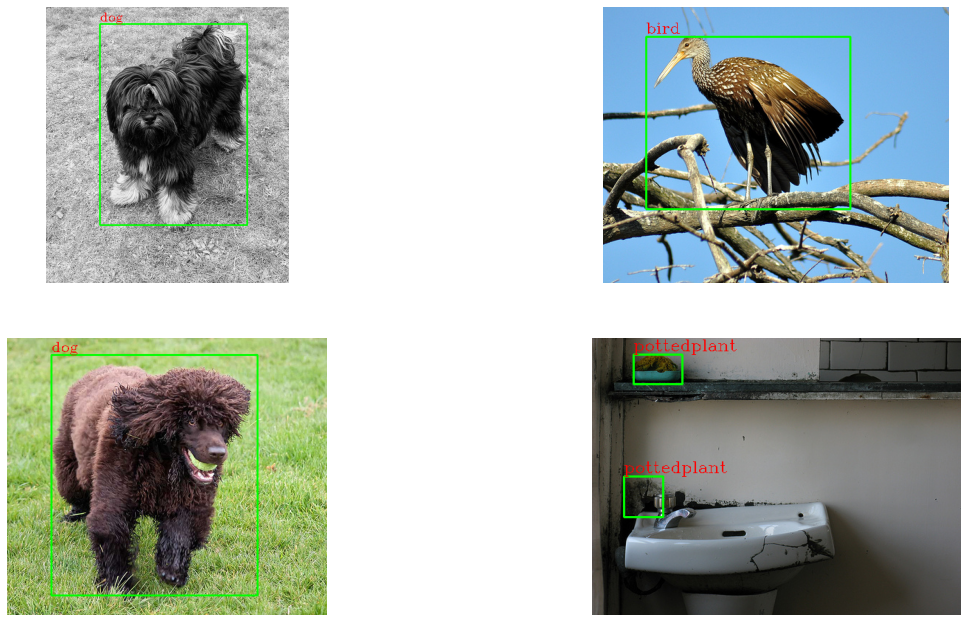

In [ ]:
pred_path = "../input/imagenet/imagenet/val/"
pred_files = [os.path.join(pred_path,f) for f in os.listdir(pred_path)]

classes= {1:'aeroplane', 2:'bicycle', 3:'bird', 4:'boat', 5:'bottle',
          6:'bus', 7:'car', 8:'cat', 9:'chair', 10:'cow',
          11:'diningtable', 12:'dog', 13:'horse', 14:'motorbike',
          15:'person', 16:'pottedplant', 17:'sheep', 18:'sofa', 
          19:'train',20:'tvmonitor'}

plt.figure(figsize=(20, 60))
image_list = [0,11,17,28]
for i, images in enumerate(pred_files):
    if i > 30:
        break
    if i not in image_list:
        continue

    plt.subplot(10,2,image_list.index(i)+1)
    
    names, boxes, sample = obj_detector(images)
    
    for i,box in enumerate(boxes):
        # 绘制包围盒
        cv2.rectangle(sample, (box[0], box[1]), (box[2], box[3]), (0, 220, 0), 2)
        cv2.putText(sample, classes[names[i]], (box[0],box[1]-5), cv2.FONT_HERSHEY_COMPLEX,
                    0.7, (220,0,0), 1, cv2.LINE_AA)  

    plt.axis('off')
    plt.imshow(sample)
